In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mnist_utils as mu
import random
import pyNN.nest as p
import relu_utils as alg
import spiking_relu as sr
import copy

In [3]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 1.,
                   'tau_syn_E': 1.0,
                   'tau_syn_I': 1.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

In [4]:
def noiseI(x, stdnoise, cell_params_lif):
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    run_s = 10.
    runtime = 1000. * run_s
    max_rate = 1000.
    #step = .1
    #x = np.arange(0., 1., step)
    count = 0
    pop_list=[]
    for i in x:
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        
        noise = p.NoisyCurrentSource(mean=i, stdev=stdnoise, start=0, stop=runtime, dt=1.0,rng=p.NativeRNG(seed=0))
        noise.inject_into(pop)
        
        #noise = p.NoisyCurrentSource(mean=-i, stdev=stdnoise, start=0, stop=runtime, dt=1.0,rng=p.NativeRNG(seed=0))
        #noise.inject_into(pop)
        
        pop_list.append(pop)
        pop.record()
        count += 1
    p.run(runtime)
    rate_I = np.zeros(count)
    for i in range(count):
        spikes = pop_list[i].getSpikes(compatible_output=True)
        rate_I[i] = len(spikes)/run_s
    p.end()
    return rate_I

In [5]:
def softplus(x, xscale=10.):
    a = 0.2
    b = 5.
    y = a * np.log(1.+ np.exp(x * b * xscale))
    #y = np.log(1.+np.exp(x*10.))
    #y = y - a * np.log(2)
    return y

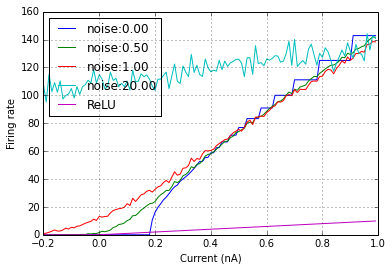

In [6]:
step = .01
x = np.arange(-0.2, 1., step)
rate_list=[]
curr = np.array([0., 0.5, 1, 20])
for stdnoise in curr: #np.arange(0.,1.,0.2):
    rate = noiseI(x, stdnoise,cell_params_lif)
    rate_list.append(rate)
    plt.plot(x, rate, label='noise:%.2f'%stdnoise,)
plt.grid('on')

plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.plot(x, softplus(x), label='ReLU')
plt.legend(loc='upper left') #, shadow=True
#plt.savefig('noise.pdf')


0.149


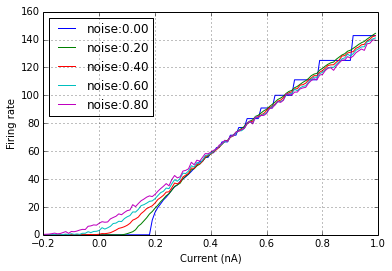

In [7]:
plt.clf()
scale = rate_list[2][70]/(softplus(x[70]))

for i in range(len(rate_list)):
    plt.plot(x, rate_list[i], label='noise:%.2f'%(i*0.2),)
#plt.plot(x, scale*softplus(x), label='Softplus')
y = rate_list[2][70]/0.5 * x
y[y<=0]=0
#plt.plot(x, y, label = 'ReLU')
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(loc='upper left') #, shadow=True
print rate_list[2][70]/0.5/1000.

In [51]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 1.,
                   'tau_syn_E': 10.0,
                   'tau_syn_I': 10.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

In [65]:
def plot_digit(img_raw, size=28, crange=(0.0, 40.)):
    #img_raw = np.uint8(img_raw)
    plt.figure(figsize=(5,5))
    im = plt.imshow(np.reshape(img_raw,(size,size)), cmap=cm.gray_r,interpolation='none', clim=crange)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()
def count_spikes(spikes, num_neuron):
    spike_count = []
    for i in range(num_neuron):
        index_i = np.where(spikes[:,0] == i)
        spike_train = spikes[index_i, 1]
        temp = sr.counter(spike_train, range(0, (10000+0)*1,10000+0), 10000)
        spike_count.append(temp)
    spike_count = np.array(spike_count)/(runtime / 1000.)
    spike_count = np.array(spike_count)
    return spike_count

In [66]:
p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
run_s = 10.
runtime = 1000. * run_s
spikes = mu.poisson_generator(1000, 0, runtime)
weights = np.arange(0.01,1.01,0.01)
pop = p.Population(1, p.SpikeSourceArray, {'spike_times' : []})
pop[0].spike_times = spikes
pop_list = []
pop_list.append(p.Population(weights.shape[0], p.IF_curr_exp, cell_params_lif))
conn_list = []
for i in range(weights.shape[0]):
    conn_list.append((0, i, weights[i], 1.))
p.Projection(pop, pop_list[-1], p.FromListConnector(conn_list))
pop_list[-1].record()
p.run(runtime)
spikes = pop_list[-1].getSpikes(compatible_output=True)
p.end()

In [67]:
spike_count = count_spikes(spikes, weights.shape[0])


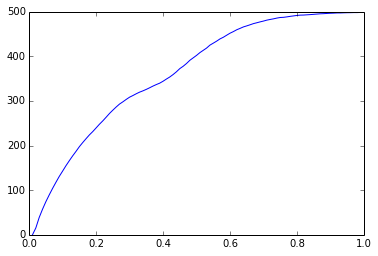

In [68]:
plt.plot(weights, spike_count[:,0])

In [41]:
range(0, (10000+0)*1,runtime+0)

TypeError: range() integer step argument expected, got float.